## Time Series Forecasting: ARMA

<strong>Refresh Data Preparation Notebook & Variables</strong>

In [ ]:
# Run Data Preperation Notebook
%run -i './Notebook_Scripts/0_Data_Preparation.py'

# Import Stored Variables
%store -r cpi_df gdp_df fedrev_df pce_df fedfunds_df feddebt_df psave_df revolcredit_df unemploy_df infl_df cc_outstanding_df merged_df dataset_dict war_timeline_df war_dates_df

print('\nEconomic datasets:')
[print(v) for k, v in dataset_dict.items()]

print('\nmerged_df:')
merged_df.tail()

Stored 'cpi_df' (DataFrame)
Stored 'gdp_df' (DataFrame)
Stored 'fedrev_df' (DataFrame)
Stored 'pce_df' (DataFrame)
Stored 'fedfunds_df' (DataFrame)
Stored 'feddebt_df' (DataFrame)
Stored 'psave_df' (DataFrame)
Stored 'revolcredit_df' (DataFrame)
Stored 'unemploy_df' (DataFrame)
Stored 'infl_df' (DataFrame)
no stored variable or alias cc_outstanding_df
no stored variable or alias merged_df
no stored variable or alias dataset_dict
no stored variable or alias war_timeline_df
no stored variable or alias war_dates_df

Economic datasets:
cpi_df
gdp_df
fedrev_df
pce_df
fedfunds_df
feddebt_df
psave_df
revolcredit_df
unemploy_df
infl_df

merged_df:
UsageError: Unknown variable 'cc_outstanding_df'


,DATE,CPI,GDP,FEDREV_mm_nom,PCE,FEDFUNDS,GFDEBTN,PSAVERT,REVOLSL,UNRATE,INFL
936,2023-08-01,306.269,NaN,NaN,18689.9,5.33,NaN,4.2,1288.12390,3.8,3.707504
937,2023-09-01,307.481,NaN,NaN,18823.4,5.33,NaN,3.7,1292.56745,3.8,3.689903
938,2023-10-01,307.619,NaN,NaN,18864.7,5.33,NaN,3.8,1295.44619,3.9,3.232356
939,2023-11-01,NaN,NaN,NaN,NaN,5.33,NaN,NaN,NaN,NaN,NaN
940,2024-01-01,NaN,NaN,5036380.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN


<strong>Import Libraries</strong>

In [ ]:
# Import Libraries
!pip install statsmodels

import warnings
import itertools
import pandas as pd
import altair as alt
import numpy as np
import seaborn as sns
import statsmodels.api as sm
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure
import math

from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.stattools import acf
from statsmodels.tsa.arima_process import ArmaProcess
from statsmodels.tsa.arima.model import ARIMA
from sklearn.metrics import mean_squared_error
from math import sqrt

# plt.style.use('fivethirtyeight')


[notice] A new release of pip is available: 23.0.1 -> 23.3.1
[notice] To update, run: pip install --upgrade pip


In [ ]:
gdp_vietnam_df = gdp_df[(gdp_df.DATE <= '1955-11-01')] # (gdp_df.DATE >= '1950-11-01') & 
gdp_vietnam_df.head()

,DATE,GDP
0,1947-01-01,243.164
1,1947-04-01,245.968
2,1947-07-01,249.585
3,1947-10-01,259.745
4,1948-01-01,265.742


### Stationarity, Differencing, & Correlation

<strong>Stationarity</strong>

All GDP Data


<AxesSubplot: >

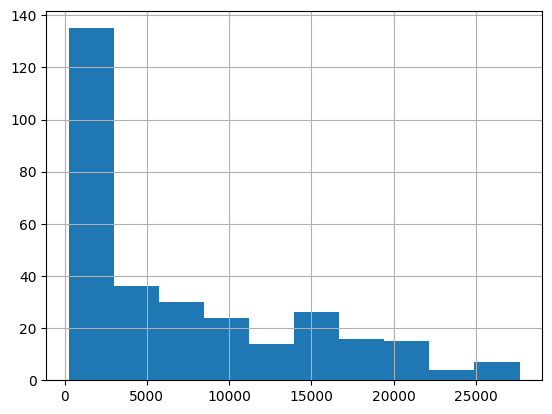

In [ ]:
# All GDP Data
print('All GDP Data')
gdp_df.GDP.hist()

GDP Before 1955 (circa Vietnam War time period)


<AxesSubplot: >

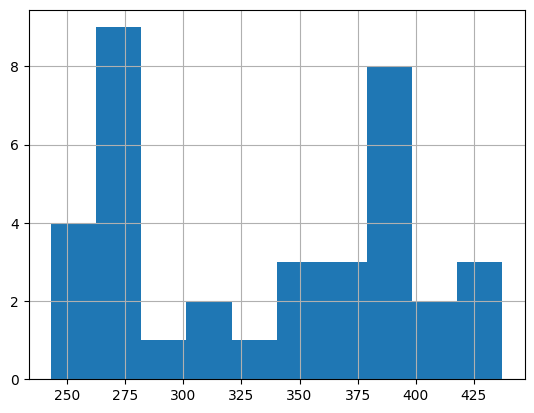

In [ ]:
# GDP Before 1980 (circa Vietnam War time period)
print('GDP Before 1955 (circa Vietnam War time period)')
gdp_df[gdp_df.DATE <= '1955-11-01'].GDP.hist()

> GDP distribution does not appear to be a Gaussian distribution, even when filtering for the Vietnam War time period. We will conduct a log transformation on GDP data to flatten the data into a linear relationship.

GDP Before 1980 with Log Transformation


<AxesSubplot: >

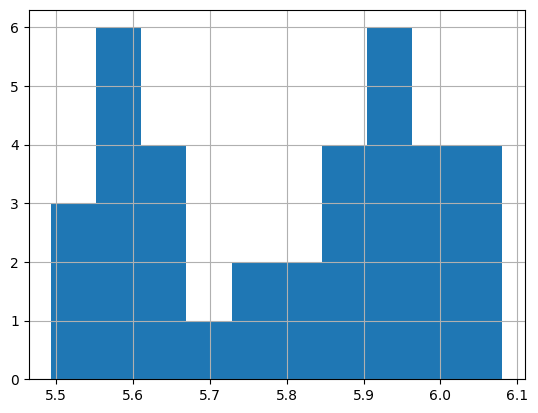

In [ ]:
# GDP Before 1980 with Log Transformation
print('GDP Before 1980 with Log Transformation')
gdp_log_vietnam_df = np.log(gdp_df[gdp_df.DATE <= '1955-11-01'].GDP)
gdp_log_vietnam_df.hist()

> GDP data now appears to be more familiar to Guassian-like or Uniform-like distribution.

GDP without Log Transformation


<AxesSubplot: >

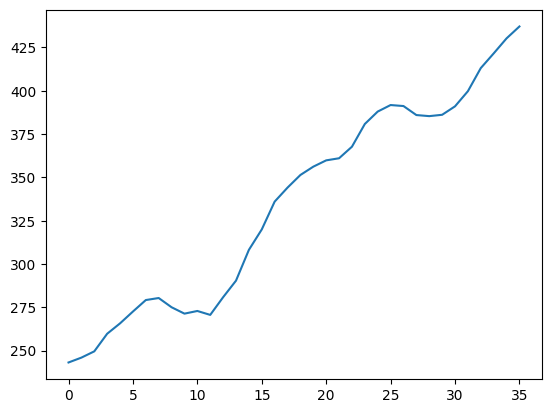

In [ ]:
# GDP (without Log Transformation)
print('GDP without Log Transformation')
gdp_df[gdp_df.DATE <= '1955-11-01'].GDP.plot()

GDP with Log Transformation


<AxesSubplot: >

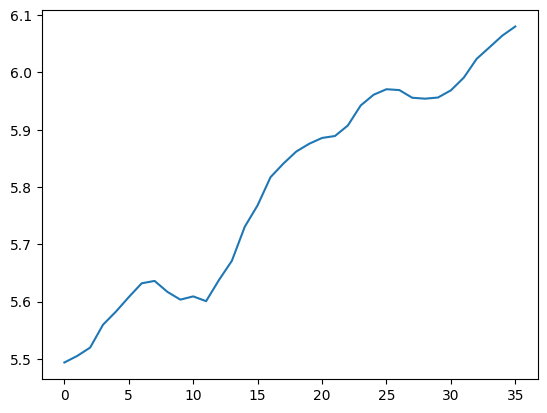

In [ ]:
# GDP with Log Transformation
print('GDP with Log Transformation')
gdp_log_vietnam_df.plot()

> From the plots we deduce that non-transformed GDP is non-stationary, and transformed GDP may be stationary. An ADF test is conducted below to further check for stationarity.

<strong>Augmented Dickey-Fuller Test</strong>

In [ ]:
# Sourced from: https://machinelearningmastery.com/time-series-data-stationary-python/
from statsmodels.tsa.stattools import adfuller

def check_stationarity(series):

    result = adfuller(series.values)

    print('ADF Statistic: %f' % result[0])
    print('p-value: %f' % result[1])
    print('Critical Values:')
    for key, value in result[4].items():
        print('\t%s: %.3f' % (key, value))

    if (result[1] <= 0.05) & (result[4]['5%'] > result[0]):
        print("\u001b[32mStationary\u001b[0m")
    else:
        print("\x1b[31mNon-stationary\x1b[0m")

In [ ]:
print('Check Stationarity: GDP\n')
check_stationarity(gdp_df.GDP)

Check Stationarity: GDP

ADF Statistic: 8.649396
p-value: 1.000000
Critical Values:
	1%: -3.452
	5%: -2.871
	10%: -2.572
Non-stationary


In [ ]:
print('Check Stationarity: GDP with Log Transformation\n')
check_stationarity(np.log(gdp_df.GDP))

Check Stationarity: GDP with Log Transformation

ADF Statistic: -2.114710
p-value: 0.238641
Critical Values:
	1%: -3.452
	5%: -2.871
	10%: -2.572
Non-stationary


In [ ]:
print('Check Stationarity: GDP (Vietnam War time period)\n')
check_stationarity(gdp_df[gdp_df.DATE <= '1955-11-01'].GDP)

Check Stationarity: GDP (Vietnam War time period)

ADF Statistic: 0.215220
p-value: 0.973102
Critical Values:
	1%: -3.654
	5%: -2.957
	10%: -2.618
Non-stationary


In [ ]:
print('Check Stationarity: GDP with Log Transformation\n(Vietnam War time period)\n')
check_stationarity(np.log(gdp_df[gdp_df.DATE <= '1955-11-01'].GDP))

Check Stationarity: GDP with Log Transformation
(Vietnam War time period)

ADF Statistic: -0.460822
p-value: 0.899438
Critical Values:
	1%: -3.661
	5%: -2.961
	10%: -2.619
Non-stationary


> GDP data, whether non-transformed or log-transformed, is non-stationary, therefore, we will transform the data via "differencing" to attempt to convert the data to stationary.

<strong>Differencing</strong>

1      2.804
2      3.617
3     10.160
4      5.997
5      6.825
6      6.629
7      1.170
8     -5.332
9     -3.683
10     1.538
Name: GDP, dtype: float64


<AxesSubplot: >

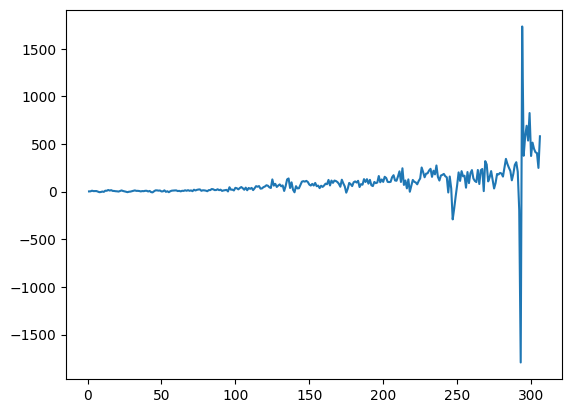

In [ ]:
# Differencing
gdp_diff = gdp_df.GDP.diff(1)
gdp_diff.dropna(inplace=True)

print(gdp_diff[:10])
gdp_diff.plot()

In [ ]:
print('Check Stationarity: GDP with Diff 1)\n')
check_stationarity(gdp_diff) 

Check Stationarity: GDP with Diff 1)

ADF Statistic: -3.867741
p-value: 0.002286
Critical Values:
	1%: -3.452
	5%: -2.871
	10%: -2.572
Stationary


> By performing a difference transformation with lag = 1, we were able to successfully convert GDP data to stationary. 

In [ ]:
# Create Differencing Dataframe
gdp_diff_df = pd.DataFrame(zip(gdp_df.DATE[1:], gdp_diff), columns=['DATE', 'GDP'])
gdp_diff_df.head()

,DATE,GDP
0,1947-04-01,2.804
1,1947-07-01,3.617
2,1947-10-01,10.160
3,1948-01-01,5.997
4,1948-04-01,6.825


In [ ]:
# Store Differencing Dataframes in Global Variable
gdp_vietnam_diff_df = gdp_diff_df[gdp_diff_df.DATE <= '1955-11-01']

%store gdp_diff_df gdp_vietnam_diff_df

Stored 'gdp_diff_df' (DataFrame)
Stored 'gdp_vietnam_diff_df' (DataFrame)


> We will be using difference (lag=1) for time series forecasting, meaning we will explore the use of the ARIMA model which includes differencing in its predictions.

<strong>ACF & PACF Plots</strong>

<img src="image-20231207-190947.png" width="" align="left" />

In [ ]:
def arima_predictions_graph(pred_df):

    fig, ax = plt.subplots(figsize=(10,5))
    ax.plot(pred_df.DATE, pred_df.Actual, label='Actual')
    ax.plot(pred_df.DATE, pred_df.Predict_Mean, label='Predict_Mean')
    ax.fill_between(pred_df.DATE, pred_df.Upper, pred_df.Lower, color='k', alpha=0.1)
    ax.legend()
    plt.xticks(rotation=45)
    plt.show()

In [ ]:
# ACF & PACF Graphs
def acf_pacf_graphs(df):

    fig, axes = plt.subplots(1, 2, figsize=(15,5))
    plot_acf(df.iloc[:,1:2].values.squeeze(), lags=20, ax=axes[0])
    plot_pacf(df.iloc[:,1:2].values.squeeze(), lags=10, ax=axes[1])
    plt.show()

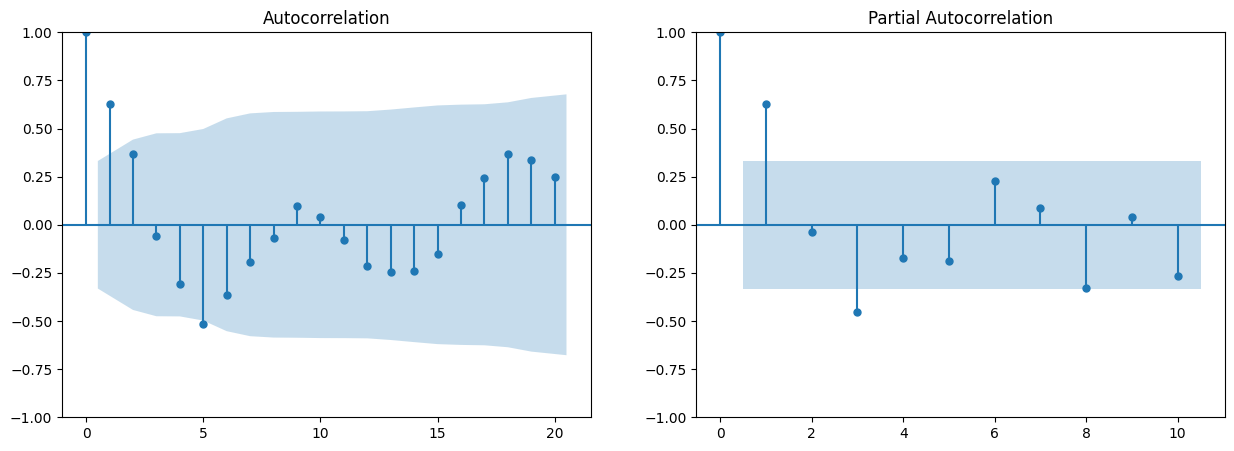

In [ ]:
acf_pacf_graphs(gdp_vietnam_diff_df)

ValueError: could not broadcast input array from shape (16,) into shape (21,)

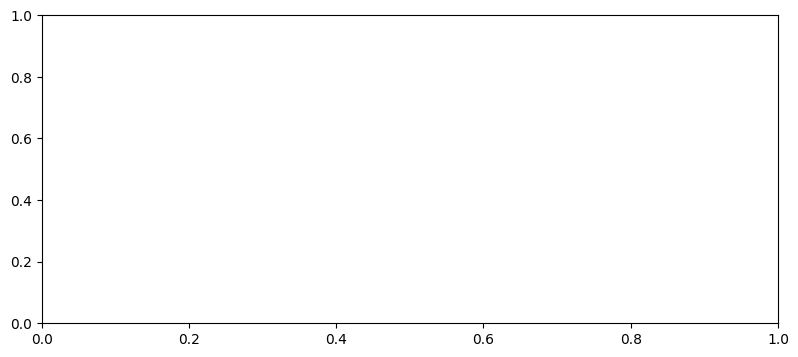

In [ ]:
# ACF Plot (indirect and direct effects)
plt.rcParams['figure.figsize'] = [9.5, 4]
arma_acf = acf(gdp_vietnam_df.GDP)
acf_plot = plot_acf(arma_acf, lags=20)

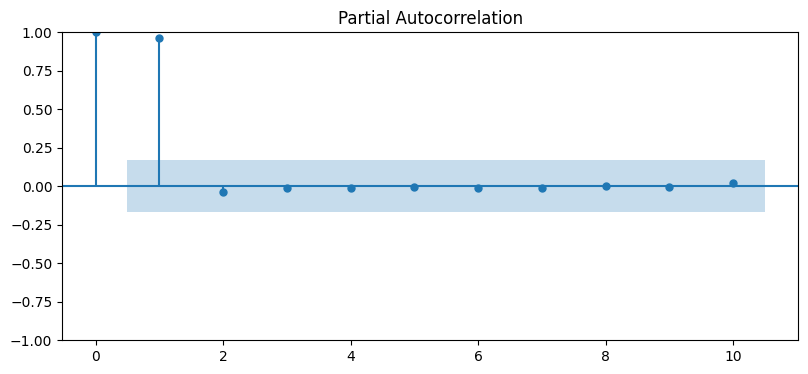

In [ ]:
# PACF Plot (direct effects)
plt.rcParams['figure.figsize'] = [9.5, 4]
pacf_plot = plot_pacf(gdp_vietnam_df.GDP, lags=10, method='ywmle')

<strong>ACF and PACF findings for non-Diff</strong>:
- There are several autocorrelations that are significantly non-zero, therefore, the time series is non-random. 
- Geometric decay in ACF plot.
- High degree of autocorrelation between adjacent (lag=1) in PACF plot. 
- Based on these findings, we can use the AR(1) model.

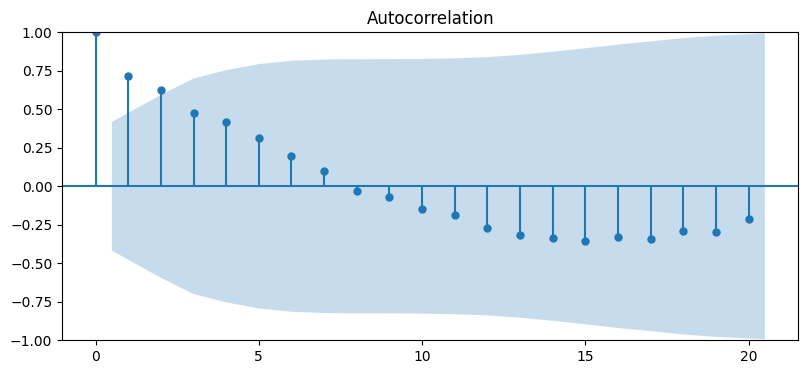

In [ ]:
# ACF Plot (indirect and direct effects)
plt.rcParams['figure.figsize'] = [9.5, 4]
arma_acf = acf(gdp_vietnam_diff_df.GDP) # gdp_vietnam_df
acf_plot = plot_acf(arma_acf, lags=20)

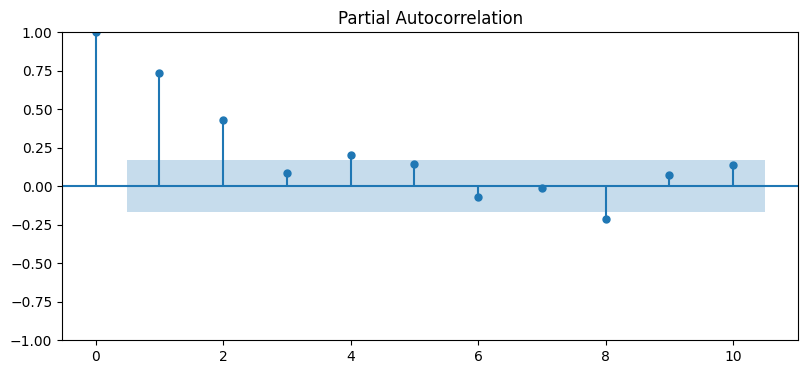

In [ ]:
# PACF Plot (direct effects)
plt.rcParams['figure.figsize'] = [9.5, 4]
pacf_plot = plot_pacf(gdp_vietnam_diff_df.GDP, lags=10, method='ywmle') # gdp_vietnam_df

<strong>ACF and PACF findings for Diff (lag=1)</strong>:
- There are several autocorrelations that are significantly non-zero, therefore, the time series is non-random. 
- Geometric decay in ACF plot, and geometric decay in PACF plot.
- Based on these findings, in addition to the difference (lag=1), we can use the ARIMA model.

> Based on the Stationarity, ACF, and PACF findings, we will attempt the ARIMA(2,1,2) model for time series forecasting.

### Determining the Best Performing Model

The Autoregressive Integrated Moving Average (ARIMA) model is a time series forecasting model that stems from the ARMA model, otherwise known as the Autoregressive Moving Average (ARMA) model. Let's review each component of ARIMA below. 

The Autoregressive model (AR) makes predictions on previously observed values, where p specifies the number of previous data points to analyze. The Moving Average model (MA) adjusts the model based on the average prediction errors from the previous q observations, therefore q determines the number of error terms to include in the moving average window. Integrated (I) introduces differencing, as specified by parameter d, to address when a trend has been observed in the time series data, ie non-stationary data. 

ARIMA(p, d, q): ARIMA(number of previous data points, difference, number of previous errors)

In [ ]:
# ARIMA(2,1,2)
ARIMA_model =ARIMA(gdp_df.GDP, order=(2,1,2), enforce_stationarity=True).fit()
print(ARIMA_model.summary())

                               SARIMAX Results                                
Dep. Variable:                    GDP   No. Observations:                  307
Model:                 ARIMA(2, 1, 2)   Log Likelihood               -2004.717
Date:                Fri, 08 Dec 2023   AIC                           4019.434
Time:                        22:48:42   BIC                           4038.052
Sample:                             0   HQIC                          4026.880
                                - 307                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.7730      0.189      4.098      0.000       0.403       1.143
ar.L2          0.2249      0.190      1.185      0.236      -0.147       0.597
ma.L1         -0.8251      0.184     -4.479      0.0

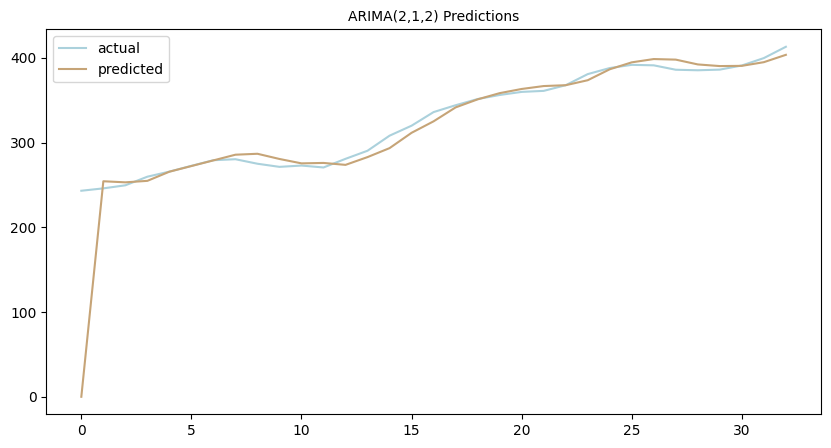

In [ ]:
# Generate ARIMA Predictions
gdp_test = gdp_df[gdp_df.DATE < '1955-04-01']
gdp_pred = ARIMA_model.predict(end=len(gdp_test)-1) # end=32

# Plot Actual vs Predicted
fig = plt.figure(figsize=(10, 5))
plt.title('ARIMA(2,1,2) Predictions', fontsize=10)
plt.plot(gdp_test.GDP, label='actual', color='#ABD1DC')
plt.plot(gdp_pred, label='predicted', color='#C6A477')
plt.legend(fontsize=10, loc='upper left')

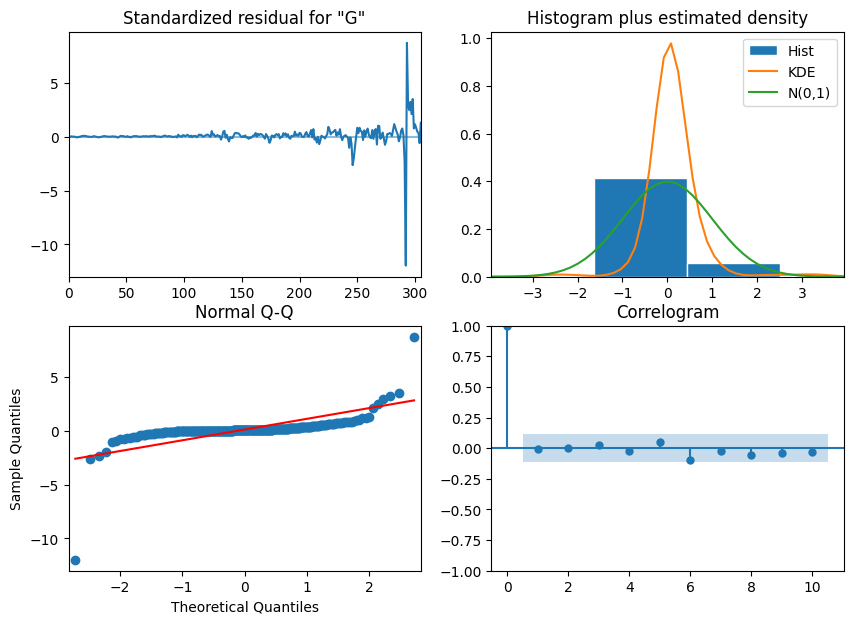

In [ ]:
# ARIMA Model Diagnostics
ARIMA_model.plot_diagnostics(figsize=(10,7))
plt.show()

<strong>ARIMA(2,1,2) Model Diagnostics</strong>
Checking the model output to ensure the model residuals are uncorrelated and normally distributed with a zero-mean.
- Standardize Residual: Residuals do not appear to show seasonality, trend, or any other non-stationarity behavior.
- Q-Q Plot: Residuals are close to normally distributed, but could still improve. 
- Histogram: Residuals do not follow KDE or N(0,1) distribution.  
- Correlogram (ACF): Resideuals have low correlation with lagged versions of itself.

In [ ]:
# RMSE Check
rmse = sqrt(mean_squared_error(gdp_test.GDP[1:], gdp_pred[1:]))
print("RMSE:", round(rmse,2))

RMSE: 6.62


> Here we see non-significant values for the coefficients ar.L2 and ma.L2. Let's adjust the model and attempt ARIMA(2,1,1). 

In [ ]:
# ARIMA(2,1,1)
ARIMA_model = ARIMA(gdp_df.GDP, order=(2,1,1), enforce_stationarity=True).fit()
print(ARIMA_model.summary())

                               SARIMAX Results                                
Dep. Variable:                    GDP   No. Observations:                  307
Model:                 ARIMA(2, 1, 1)   Log Likelihood               -2004.753
Date:                Fri, 08 Dec 2023   AIC                           4017.506
Time:                        22:48:42   BIC                           4032.400
Sample:                             0   HQIC                          4023.463
                                - 307                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.8547      0.024     35.406      0.000       0.807       0.902
ar.L2          0.1432      0.022      6.635      0.000       0.101       0.186
ma.L1         -0.9079      0.023    -39.276      0.0

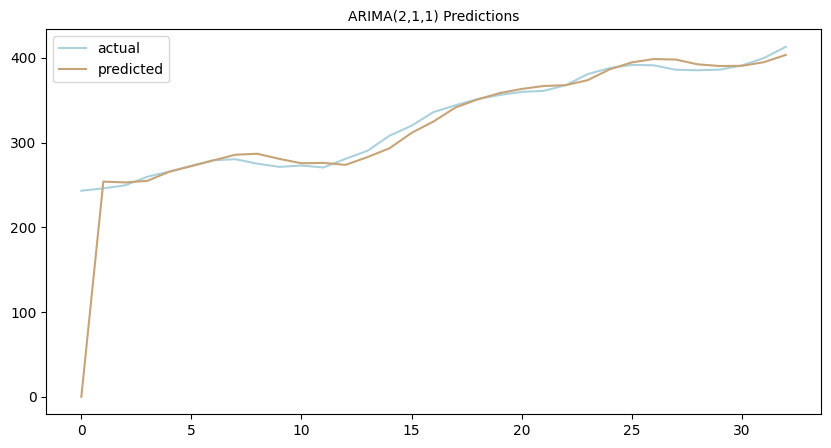

In [ ]:
# Generate ARIMA Predictions
gdp_test = gdp_df[gdp_df.DATE < '1955-04-01']
gdp_pred = ARIMA_model.predict(end=len(gdp_test)-1) # end=32

# Plot Actual vs Predicted
fig = plt.figure(figsize=(10,5))
plt.title('ARIMA(2,1,1) Predictions', fontsize=10)
plt.plot(gdp_test.GDP, label='actual', color='#ABD1DC')
plt.plot(gdp_pred, label='predicted', color='#C6A477')
plt.legend(fontsize=10, loc='upper left')

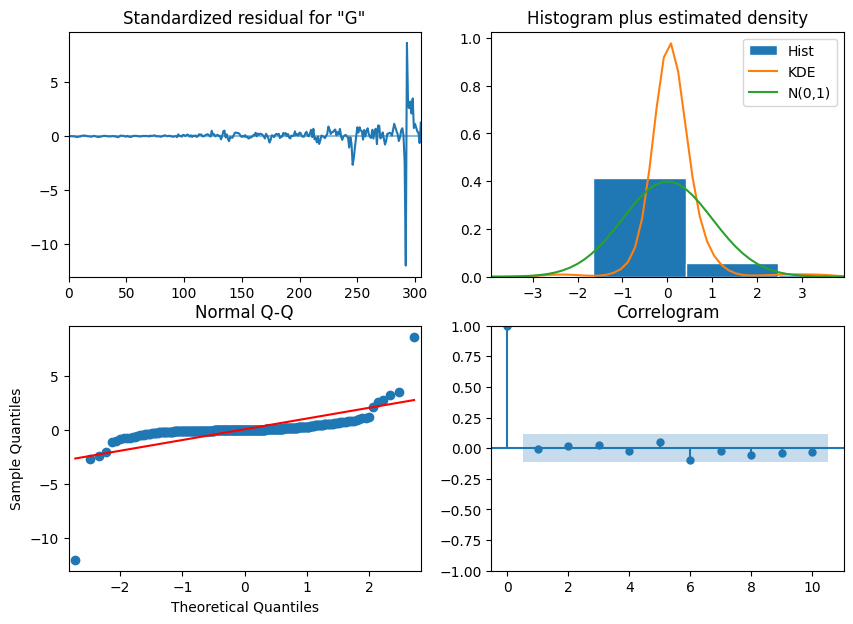

In [ ]:
# ARIMA Model Diagnostics
ARIMA_model.plot_diagnostics(figsize=(10,7))
plt.show()

<strong>ARIMA(2,1,1) Model Diagnostics</strong>
Checking the model output to ensure the model residuals are uncorrelated and normally distributed with a zero-mean.
- Standardize Residual: Residuals do not appear to show seasonality, trend, or any other non-stationarity behavior.
- Q-Q Plot: Residuals are close to normally distributed, but could still improve. 
- Histogram: Residuals do not follow KDE or N(0,1) distribution.  
- Correlogram (ACF): Resideuals have low correlation with lagged versions of itself.

In [ ]:
# RMSE Check
rmse = sqrt(mean_squared_error(gdp_test.GDP[1:], gdp_pred[1:]))
print("RMSE:", round(rmse,2))

RMSE: 6.64


<strong>Comparing ARIMA(2,1,2) to ARIMA(2,1,1) model performance summaries</strong>:
- 2 coefficients show non-sigficants for ARIMA(2,1,2) vs all coefficients show significance for ARIMA(2,1,1)
- Log Likelihood are the same for both models
- ARIMA(2,1,1) has lower AIC
- ARIMA(2,1,2) has lower RMSE

> Based on these findings, we will use the ARIMA(2,1,1) model.

### ARIMA Model

In [ ]:
# Split Train and Test Data
gdp_vietnam_df = gdp_df[gdp_df.DATE < '1980-01-01']
gdp_vietnam_train_df = gdp_df[gdp_df.DATE <= '1955-04-01']
gdp_vietnam_test_df = gdp_df[(gdp_df.DATE >= '1955-04-01') & (gdp_df.DATE <= '1980-01-01')]

print(gdp_vietnam_train_df.head(),'\n')
print(gdp_vietnam_test_df.head())

         DATE      GDP
0  1947-01-01  243.164
1  1947-04-01  245.968
2  1947-07-01  249.585
3  1947-10-01  259.745
4  1948-01-01  265.742 

          DATE      GDP
33  1955-04-01  421.532
34  1955-07-01  430.221
35  1955-10-01  437.092
36  1956-01-01  439.746
37  1956-04-01  446.010


f, ax = plt.subplots(nrows=1, ncols=1, figsize=(12, 4))
sns.lineplot(x=sample.timestamp[train_len:num_samples], y=sample.t[train_len:num_samples], marker='o', label='test', color='grey')
sns.lineplot(x=sample.timestamp[:train_len], y=train, marker='o', label='train')
sns.lineplot(x=sample.timestamp[train_len:num_samples], y=pred, marker='o', label='pred')
ax.set_xlim([sample.timestamp.iloc[0], sample.timestamp.iloc[-1]])
ax.set_title('Sample Time Series')
plt.tight_layout()
plt.show()

<strong>Plot Graph</strong>

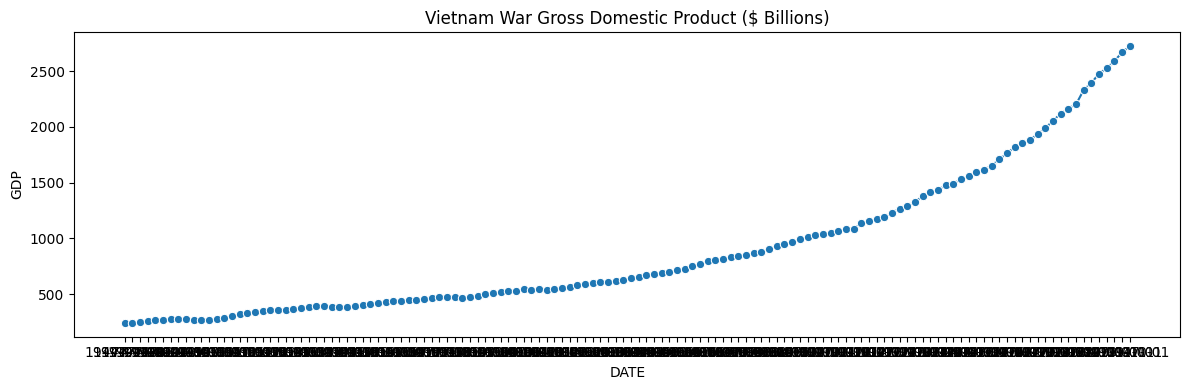

In [ ]:
f, ax = plt.subplots(nrows=1, ncols=1, figsize=(12, 4))
sns.lineplot(x=gdp_vietnam_df.DATE, y=gdp_vietnam_df.GDP, marker='o')

ax.set_title('Vietnam War Gross Domestic Product ($ Billions)')
plt.tight_layout()
plt.show()

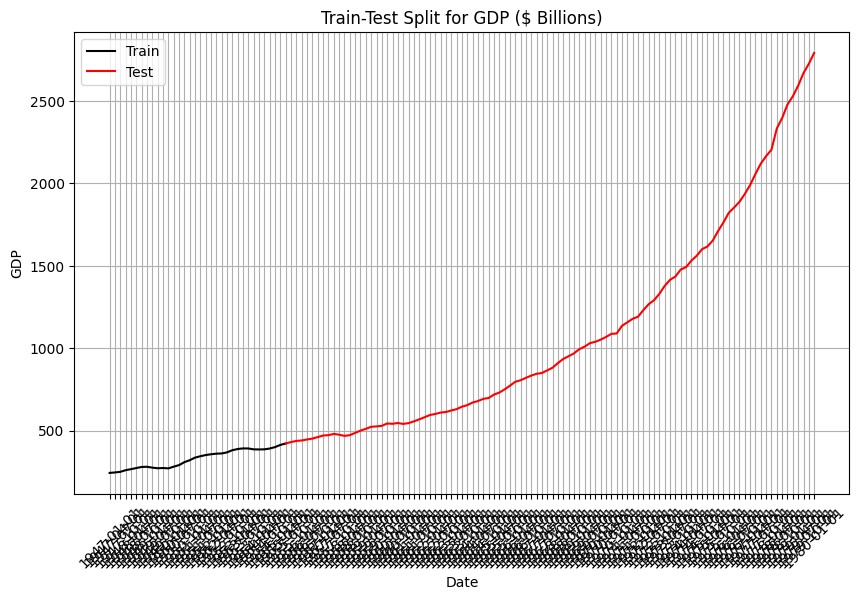

In [ ]:
# Plot Train, Test
plt.figure(figsize=(10,6))
plt.ylabel('GDP')
plt.xlabel('Date')
plt.plot(gdp_vietnam_train_df.DATE, gdp_vietnam_train_df.GDP, color='black', label='Train')
plt.plot(gdp_vietnam_test_df.DATE, gdp_vietnam_test_df.GDP, color='red', label='Test')
plt.xticks(rotation=45)
plt.title('Train-Test Split for GDP ($ Billions)')
plt.legend()
plt.grid(True)
plt.show()

In [ ]:
  # ARIMA Model
# y = gdp_vietnam_train.GDP
# ARIMA_model = ARIMA(y, order=(2,1,1), enforce_stationarity=True).fit()

# ARIMA(2,1,1)
# ARIMA_model =ARIMA(gdp_vietnam_df.GDP, order=(2,1,1), enforce_stationarity=True).fit()
# print(ARIMA_model.summary())

# Generate ARIMA Predictions
# gdp_train = gdp_df[gdp_df.DATE < '1955-04-01']
# gdp_pred = ARIMA_model.predict(end=len(gdp_vietnam_df)-1)


In [ ]:
# ARIMA Model Predictions

def arima_predictions(df,p,d,q):

  ARIMA_model = ARIMA(df.iloc[:,1:2], order=(p,d,q), enforce_stationarity=True).fit()
  pred_df = pd.DataFrame(columns=['DATE','Actual','Lower','Upper','Predict_Mean'])
  pred_df.DATE = df.DATE
  pred_df.Actual = df.iloc[:,1:2]

  # Get Forecast
  # pred_df.Upper = ARIMA_model.get_forecast(len(df)).conf_int(alpha=0.05)[0]
  # pred_df.Lower = ARIMA_model.get_forecast(len(df)).conf_int(alpha=0.05)[1]
  # pred_df.Prediction = ARIMA_model.get_forecast(len(df)).predicted_mean

  # Get Prediction
  # pred_df.Prediction = ARIMA_model.predict(start=df.index[0], end=df.index[-1])
  pred = ARIMA_model.get_prediction(start=df.index[0], end=df.index[-1], dynamic=False)
  pred_df.Predict_Mean = ARIMA_model.predict(start=df.index[0], end=df.index[-1])

  pred_ci = pred.conf_int(alpha=0.05)
  pred_df.Upper = pred_ci.iloc[:,1:].values
  pred_df.Lower = pred_ci.iloc[:,:1].values

  return pred_df

In [ ]:
arima_predictions(gdp_vietnam_df,2,1,1)

,DATE,Actual,Lower,Upper,Predict_Mean
0,1947-01-01,243.164,-1961.821177,1961.821177,0.000000
1,1947-04-01,245.968,158.326622,328.869743,243.598183
2,1947-07-01,249.585,220.363838,276.913433,248.638635
3,1947-10-01,259.745,228.211425,277.198445,252.704935
4,1948-01-01,265.742,241.806131,288.496823,265.151477
...,...,...,...,...,...
127,1978-10-01,2476.949,2441.164032,2485.981505,2463.572769
128,1979-01-01,2526.610,2525.236715,2570.054188,2547.645451
129,1979-04-01,2591.247,2571.237069,2616.054542,2593.645806
130,1979-07-01,2667.565,2633.983162,2678.800635,2656.391898


NameError: name 'train' is not defined

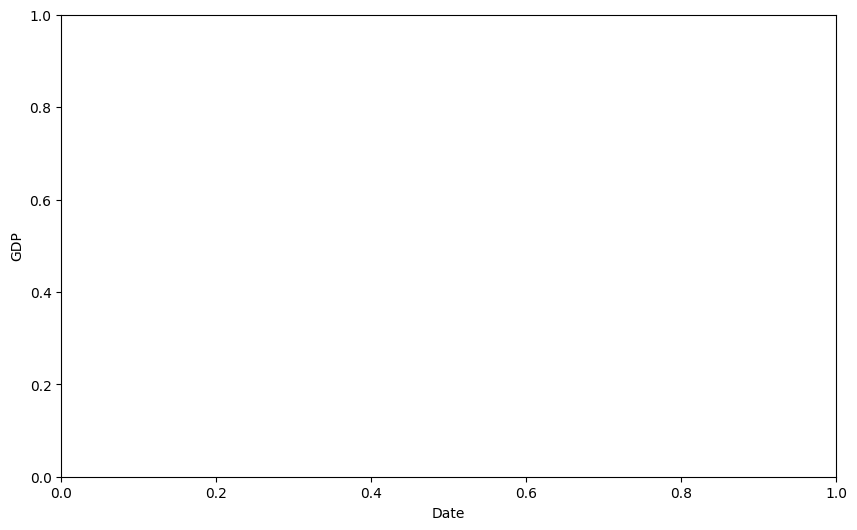

In [ ]:
# Plot ARMA Prediction
plt.figure(figsize=(10,6))
plt.ylabel('GDP')
plt.xlabel('Date')
plt.plot(train.DATE, train.GDP, color='black', label='Train')
plt.plot(test.DATE, test.GDP, color='red', label='Test')
plt.plot(test.DATE, y_pred_out.values, color='green', label='ARMA Prediction')
plt.xticks(rotation=45)
plt.title("Train, Test, & Predictions for GDP ($ Billions)")
plt.legend()
plt.grid(True)
plt.show()

print(test,'\n')
print(y_pred_out)

In [ ]:
# ARMA Root Mean Squared Error (RMSE)
arma_rmse = np.sqrt(mean_squared_error(test.GDP.values, y_pred_df.Prediction))
print("RMSE: ",arma_rmse)

RMSE:  9.326625669069664


<a style='text-decoration:none;line-height:16px;display:flex;color:#5B5B62;padding:10px;justify-content:end;' href='https://deepnote.com?utm_source=created-in-deepnote-cell&projectId=ba1e4b21-f3e5-4d67-887d-75e6f1b74e8f' target="_blank">
 </img>
Created in <span style='font-weight:600;margin-left:4px;'>Deepnote</span></a>